### Initial guess selection with `multicube`: a multiple component case

This example picks up where `example.ipynb` notebook ended. This notebook illustrates an example usage the SubCube routines to select an optimal starting guess for the case of double velocity component model.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import pyspeckit
from multicube.subcube import SubCube
from multicube.astro_toolbox import make_test_cube, get_ncores
from IPython.utils import io
import warnings
warnings.filterwarnings('ignore')

Let's first make a test FITS file, containing a mixture of synthetic signal with some noise put on top of it. The created spectral cube will be 10x10 pixels wide in the plain of sky and 300 pixels "long" along its spectral axis.

In [2]:
make_test_cube((300,10,10), outfile='foo.fits', sigma=(10,5))
sc = SubCube('foo.fits')

To make things interesting, let's introduce a radial velocity gradient in our cube along with a second, weaker component.

In [3]:
# TODO: move this to astro_toolbox.py
#       as a general synthetic cube generator routine
def tinker_ppv(arr):
    scale_roll = 15
    rel_shift  = 30
    rel_str    = 5
    shifted_component = np.roll(arr, rel_shift) / rel_str
    for y,x in np.ndindex(arr.shape[1:]):
        roll  = np.sqrt((x-5)**2 + (y-5)**2) * scale_roll
        arr[:,y,x] = np.roll(arr[:,y,x], int(roll))
    return arr + shifted_component
sc.cube = tinker_ppv(sc.cube)

This is how a sample spectrum looks like at x,y = (3,7):

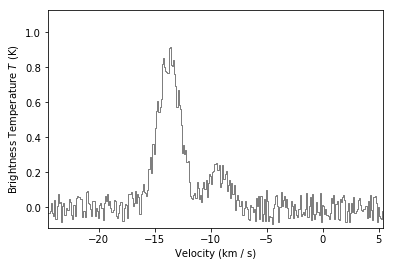

In [4]:
sc.plot_spectrum(3,7)

For this case, all we have to do is to pass an extra triple of gaussian parameters to `multicube`. Similarly to a the other example, the routine then generates a model grid in the parameter space with given spacing set by `finesse`

In [5]:
npeaks = 2
sc.update_model('gaussian')
sc.specfit.fitter.npeaks = npeaks
minpars = [0.1, sc.xarr.min().value, 0.1] + [0.1, -13, 0.5]
maxpars = [2.0, sc.xarr.max().value, 2.0] + [0.5,  -5, 1.5]
finesse = [5, 10, 5] + [5, 20, 5]
sc.make_guess_grid(minpars, maxpars, finesse)

INFO: Selected gaussian model [multicube.subcube]
INFO: Binning the 6-dimensional parameter space into a (5, 10, 5, 5, 20, 5)-shaped grid [multicube.subcube]


array([[  0.41666667, -21.78181818,   0.41666667,   0.16666667,
        -12.61904762,   0.66666667],
       [  0.41666667, -21.78181818,   0.41666667,   0.16666667,
        -12.61904762,   0.83333333],
       [  0.41666667, -21.78181818,   0.41666667,   0.16666667,
        -12.61904762,   1.        ],
       ..., 
       [  1.68333333,   2.68181818,   1.68333333,   0.43333333,
         -5.38095238,   1.        ],
       [  1.68333333,   2.68181818,   1.68333333,   0.43333333,
         -5.38095238,   1.16666667],
       [  1.68333333,   2.68181818,   1.68333333,   0.43333333,
         -5.38095238,   1.33333333]])

This grid, stored under `sc.guess_grid`, can be used to generate a number of spectral models with `pyspeckit`, and the guesses that have the least residual `rms` can be selected for the whole cube:
* `sc.best_map` stored the map between x,y pixel numbers and the numbers of corresponding best models
* `sc.best_model` is the number of the model suited best for the pixel with the highest S/N ratio.

In [6]:
sc.generate_model()
sc.get_snr_map()
sc.best_guess()

INFO: Generating spectral models from the guess grid . . . [multicube.subcube]
INFO: Calculating residuals for generated models . . . [multicube.subcube]


INFO: Overall best model: selected #13540 [  0.42 -19.06   1.05   0.17  -9.57   0.67] [multicube.subcube]
INFO: Best model @ highest SNR: #64938 [ 0.42 -8.19  1.68  0.43 -9.95  1.17] [multicube.subcube]


### Fitting the cube best models for each x,y pixel:

In [7]:
sc.fiteach(fittype   = sc.fittype,
           guesses   = sc.best_guesses, 
           multicore = get_ncores(),
           errmap    = sc._rms_map,
           **sc.fiteach_args);

INFO: Finished fit     53 of    100 at (   3,   7) s/n=  9.6. Elapsed time is 0.3 seconds.  %53 [multicube.subcube]
INFO: Finished fit      1 of    100 at (   0,   0) s/n=  4.0. Elapsed time is 0.3 seconds.  %1 [multicube.subcube]
INFO: Finished fit     27 of    100 at (   5,   1) s/n=  4.0. Elapsed time is 0.3 seconds.  %27 [multicube.subcube]
INFO: Finished fit     89 of    100 at (   9,   5) s/n=  3.9. Elapsed time is 0.3 seconds.  %89 [multicube.subcube]
INFO: Finished fit     65 of    100 at (   6,   6) s/n= 18.6. Elapsed time is 0.3 seconds.  %65 [multicube.subcube]
INFO: Finished fit     14 of    100 at (   2,   3) s/n=  4.5. Elapsed time is 0.5 seconds.  %14 [multicube.subcube]
INFO: Finished fit      2 of    100 at (   1,   0) s/n=  3.7. Elapsed time is 0.5 seconds.  %2 [multicube.subcube]
INFO: Finished fit     54 of    100 at (   7,   3) s/n=  8.9. Elapsed time is 0.5 seconds.  %54 [multicube.subcube]
INFO: Finished fit     28 of    100 at (   1,   5) s/n=  4.0. Elapsed time

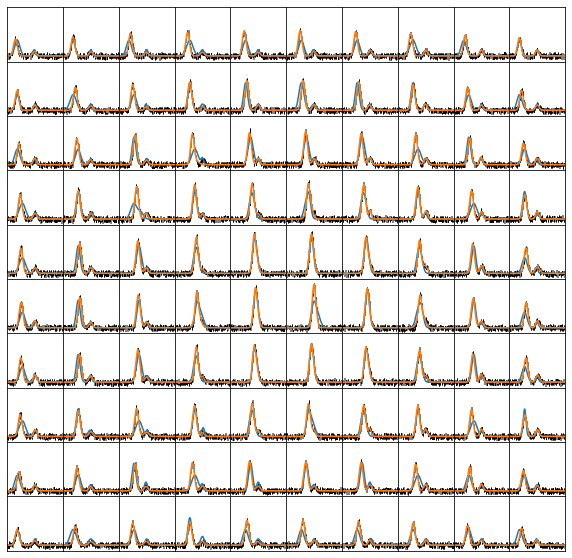

In [8]:
sc.get_modelcube()
import matplotlib.gridspec as gridspec
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(*sc.cube.shape[1:])
gs.update(wspace=0., hspace=0.)
for ii in range(np.prod(sc.cube.shape[1:])):
    xy = np.unravel_index(ii, dims=sc.cube.shape[1:])
    ax = plt.subplot(gs[ii])
    sc.plot_spectrum(*xy, axis=ax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_ylim(-0.15, 1.3)
    ax.plot(sc.xarr.value, sc.model_grid[sc._best_map[xy]], label='Initial guess\nat (x,y)={}'.format(xy))
    ax.plot(sc.xarr.value, sc._modelcube[:, xy[1], xy[0]], label='Final fit\nat (x,y)={}'.format(xy))